In [55]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
import time
from datetime import date
import os

def find_start(data):
    start_found=False
    timestamps=data['unix']
    index=len(timestamps)-1
    while not(start_found):
        day=date.fromtimestamp(timestamps.iloc[index]).weekday()
        if day==0:
            start_found=True
        else:
            index=index-1
    return timestamps.iloc[index]

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    start=find_start(raw)
    trimmed=raw.loc[raw['unix']>=start]
    return trimmed.sort_values(by=['unix'], ignore_index=True)

btc_price_data=read_data('BTCUSD_d.csv')
weekly_candles=price.get_price_data('1w',data=btc_price_data)
# candles=[]
# for i in reversed(range(len(btc_price_data))):
#     candle=btc_price_data.iloc[i]
#     candles.append((candle['unix'],candle['open'], candle['high'],candle['low'], candle['close']))

FileNotFoundError: [Errno 2] No such file or directory: 'data/BTCUSD_d.csv'

In [22]:
def get_sma(data,window, close=True):
     #using daily for now
    timestamps=data['unix'][window-1:]
    if close:
        sma=data.rolling(window).mean()['close'].dropna()
    else:
        sma=data.rolling(window).mean()['open'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':sma})

    # return pd.DataFrame({'unix': list(map(lambda x: x[0], sma)),'value':list(map(lambda x: x[1], sma))})

def get_ema(data,window, close=True):
    timestamps=data['unix'][window:]
    if close:
        ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['close'].dropna()
    else:
        ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['open'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':ema})

def risk_indicator(fast,slow):
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    trimmed_fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]
    if len(trimmed_fast)>len(slow): 
        #different values, ie using a daily for fast and weekly for slow
        if (slow['unix'].max()<trimmed_fast['unix'].max()):
            #add another value to the slow moving avarage to facilitate interpolation
            slow=slow.append({'unix': trimmed_fast['unix'].max(), 'value':slow.iloc[-1]['value']},ignore_index=True)
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)
    return pd.DataFrame({'unix':trimmed_fast['unix'],'value':risk})



In [23]:
fast=get_sma(btc_price_data,30)
fast_ema=get_ema(btc_price_data,50)
slow=get_sma(weekly_candles,30)

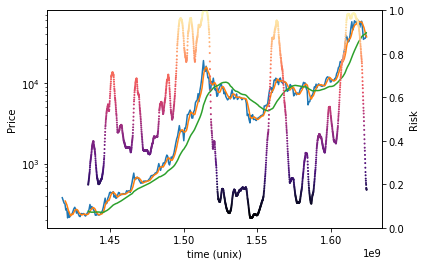

In [24]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
# ax1.plot(fast['unix'],fast['value'])

risk=risk_indicator(fast,slow)
ax1.plot(weekly_candles['unix'],weekly_candles['close'])
ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow['unix'],slow['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')  
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='magma')

(0.0, 1.0)

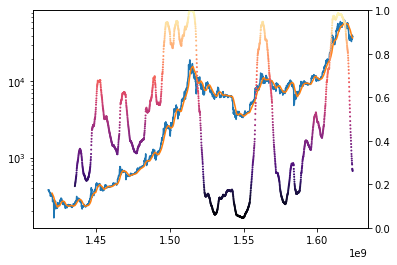

In [25]:

fig2, ax3 = plt.subplots()
ax3.plot(btc_price_data['unix'],btc_price_data['close'])
ax3.plot(fast['unix'],fast['value'])
risk2= risk_indicator(fast_ema,slow)
filtered_risk=risk2.loc[risk2['value']<0.2]
ax3.set_yscale('log')
ax4 = ax3.twinx()
ax4.scatter(risk2['unix'],risk2['value'], s=1, c=risk2['value'], cmap='magma')
ax4.set_ylim(0,1)
# ax4.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

In [26]:
def exponentially_weighted_risk(fast,slow):#places more weight on recent values to calculate the mean and standard deviation
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    trimmed_fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]
    if len(trimmed_fast)>len(slow):
        #different values, ie using a daily for fast and weekly for slow
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    df=pd.DataFrame({'unix':trimmed_fast['unix'],'risk_metric':risk_metric})
    df.dropna(inplace=True)
    n=len(df)
    mean=df.ewm(span=n,min_periods=n,adjust=False).mean()
    sigma=df.ewm(span=n,min_periods=n,adjust=False).std()

    mean.dropna(inplace=True)
    mean=mean.head(1)['risk_metric']
    sigma.dropna(inplace=True)
    sigma=sigma.head(1)['risk_metric']
    
    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)

    df['value']=risk
    return df
    # return df


In [27]:
month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}

def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=int(string[1])
    year=int(string[2])
    d=date(year,month,day)

    return int(time.mktime(d.timetuple()))
    


In [56]:
def process_coincodex_csv(filename):

    raw_data=pd.read_csv('data/'+filename)
    vectorised_parsing=np.vectorize(parse_data)
    timestamps=vectorised_parsing(raw_data['Date'].values)
    df=raw_data

    df['unix']=timestamps
    df.columns = ['date','open','high','low','close','volume','market cap','unix']
    df.sort_values(by='unix', ignore_index=True, inplace=True)
    df.to_csv('data/'+filename)

    return df

cardano=process_coincodex_csv('cardano.csv')
cardano_weekly=price.get_price_data('1w',data=cardano)

fig3, ax5 = plt.subplots()

cardano_fast=get_ema(cardano,10)
cardano_slow=get_sma(cardano_weekly,10)
ax5.plot(cardano['unix'], cardano['close'])
ax5.plot(cardano_fast['unix'], cardano_fast['value'])
cardano_risk=risk_indicator(cardano_fast,cardano_slow)
ax6 =ax5.twinx()
ax6.scatter(cardano_risk['unix'],cardano_risk['value'], s=1, c=cardano_risk['value'], cmap='magma')
ax5.set_yscale('log')

PermissionError: [WinError 5] Access is denied: 'data/cardano.csv'

In [29]:
def find_intercepts(fast,slow): #each line is a dataframe with time stamp and value, assuming both have same length
    #starting state
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]

    if len(fast) != len(slow):
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(fast['unix'])
        slow=pd.DataFrame({'unix':fast['unix'],'value':slow_interpolated})

    timestamps=fast['unix'].values
    line1=fast['value'].values
    line2=slow['value'].values

    line1_above_line2=line1[0]>line2[0] #state
    cross_above=[]
    cross_below=[]
    for i in range(len(line1)):
        if line1_above_line2 and line1[i]<line2[i]:
            cross_below.append(timestamps[i])
        elif not(line1_above_line2) and line1[i]>line2[i]:
            cross_above.append(timestamps[i])
        
        line1_above_line2 = line1[i]>line2[i]

    return {'cross_above': cross_above,'cross_below': cross_below }

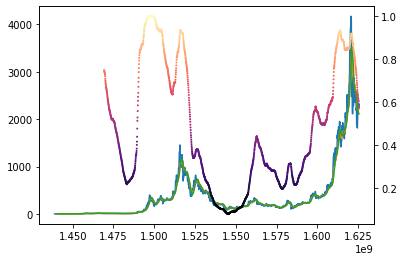

In [30]:
eth=process_coincodex_csv('ETHUSD_d.csv')
ethereum_weekly=price.get_price_data('1w',data=eth)

fig4, ax7 = plt.subplots()
ema=get_ema(eth,21)
sma=get_sma(eth,20)

eth_fast=get_ema(eth,50)
eth_slow=get_sma(ethereum_weekly,50)
ax7.plot(eth['unix'], eth['close'])
ax7.plot(ema['unix'], ema['value'])
ax7.plot(sma['unix'], sma['value'])
eth_risk=risk_indicator(eth_fast,eth_slow)
#ax7.set_xlim(1600000000,1630000000)
ax8 =ax7.twinx()
ax8.scatter(eth_risk['unix'],eth_risk['value'], s=1, c=eth_risk['value'], cmap='magma')
# ax7.vlines(find_intercepts(ema,sma)['cross_above'],0,eth['close'].max(), colors='r')
# ax7.vlines(find_intercepts(ema,sma)['cross_below'],0,eth['close'].max(), colors='b')
#ax7.set_yscale('log')

In [31]:
def ma_channel(data, window):
    timestamps=data['unix']
    sma=data.rolling(window).mean()
    sma['unix']=timestamps
    sma.dropna(inplace=True)    

    return pd.DataFrame({'unix':sma['unix'],'high':sma['high'], 'low':sma['low'], 'open':sma['open']})



In [32]:
def backtest_ma_channel(data,period, slow_ma_gradient):
    print('Datapoints: ',len(data))
    equity=1000

    channel=ma_channel(data,period)
    start=channel['unix'].min()
    trimmed_data=channel.loc[channel['unix']>=start]

    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    for i in range(len(channel)):
        upper_bound=channel.iloc[i]['high']
        lower_bound=channel.iloc[i]['low']
        time=channel.iloc[i]['unix']
        day=max(filter(lambda x: x<time,list(slow_ma_gradient.index)))
        five_opens=data.loc[data['unix']<=time].tail(n=5)['open'].values # uses opens now as opens are confirmed
        uptrend=slow_ma_gradient.loc[day]>0
        
        current=five_opens[-1]
        if all(opens>upper_bound for opens in five_opens) and state != 'long' and uptrend.all():
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                # equity=(entry*trade_amount-current*trade_amount)+equity
            state='long'
            entry=current
            
            # trade_amount=equity*entry
            longs.append(time)
            #print(state+' from $'+str(current))
        elif all(opens<lower_bound for opens in five_opens) and state != 'short' and not(uptrend.all()):
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                # equity=(current*trade_amount-entry*trade_amount)+equity
            entry=current
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))

        # else:
        #     if state=='long':
        #         equity=trade_amount*current
        #     elif state=='short':
        #         equity=(entry*trade_amount-current*trade_amount)+equity
        
        #print(equity)
        # equity_record.append(equity)
    
    return longs,shorts,np.array(outcome), np.array(profit)#pd.DataFrame({'unix':channel['unix'],'equity':equity_record})

def get_gradient(ma):
    
    return pd.Series(
        index=ma['unix'].values,
        data=np.gradient(ma['value'])
    )



# equity_curve=backtest_ma_channel(eth_hourly,20)[2]


In [33]:
eth_hourly=read_data('ETHUSD_h.csv')
channel=ma_channel(eth_hourly,20)


In [34]:

# results=[]
# for ema_period in range(20,30):
#     print('ema=', ema_period)
#     ema=get_ema(eth,ema_period,False)
#     gradient=get_gradient(ema)
#     for ma_channel_period in range(10,20):
#         print('ma=', ma_channel_period)
#         longs, shorts, outcome, profit=backtest_ma_channel(eth_hourly, ma_channel_period,gradient)
#         print(np.sum(outcome)/len(outcome))
#         print(np.mean(profit))
#         results.append([ema_period,ma_channel_period,np.sum(outcome)/np.size(outcome),profit])

In [35]:
#results_df=pd.DataFrame(np.array(results),columns=['ema','channel','success_rate','profit'])

In [60]:
ema=get_ema(eth,12, False)
gradient=get_gradient(ema)
start_time=time.time()
longs, shorts, outcome, profit=backtest_ma_channel(eth_hourly, 18,gradient)
print('number of trades:',len(outcome))
print('max_drawdown=',profit.min())
end_time=time.time()

Datapoints:  27465
number of trades: 109
max_drawdown= -0.07033222853535359


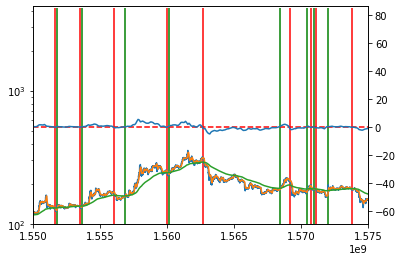

In [44]:
fig1, ax1 = plt.subplots()
ax1.plot(eth_hourly['unix'],eth_hourly['close'])
ax1.plot(channel['unix'],channel['high'])
ax1.plot(ema['unix'],ema['value'])

ax1.vlines(longs,0,eth['close'].max(), colors='g')
ax1.vlines(shorts,0,eth['close'].max(), colors='r')
ax1.set_yscale('log')
ax1.set_ylim(100,4300)
# ax1.set_xlim(eth['unix'].min(),eth['unix'].max())
ax1.set_xlim(1550000000,1575000000)
ax2=ax1.twinx()
#ax2.set_ylim(-20,20)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.plot(gradient.index,gradient.values)

In [45]:
print(np.sum(outcome)/len(outcome))
np.mean(profit)

0.8823529411764706


0.21419230801807446

In [40]:
def conditional_risk(data,ma_period):
    #identify probability of uptrend and downtrend on moving average
    ma=get_ema()
    #identify P(risk_metric,trend)=P(trend|risk_metric)*P(risk_metric)

    #Risk=P(risk_metric|trend)=P(risk_metric,trend)/P(trend)
    pass

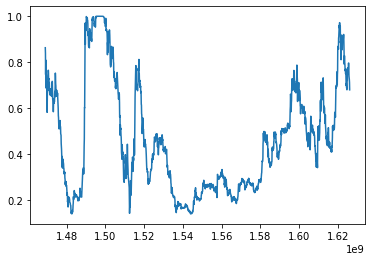

In [42]:
ethbtc=process_coincodex_csv('ETHBTC_d.csv')
risk=risk_indicator(ethbtc,get_sma(ethbtc,350))
fig1,ax1 = plt.subplots()
ax1.plot(risk['unix'],risk['value'])

In [62]:
def update_csv(symbol,timeframe):
    
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    filename=base_currency+quote_currency+'_'+timeframe+'.csv'
    old_data=pd.read_csv('data/'+filename)
    print(old_data)
    max_timestamp=old_data['unix'].max()

    latest_price_data=price.get_price_data(symbol,interval,since=max_timestamp)

    new_data=latest_price_data[latest_price_data['unix']>=max_timestamp]
    old_data.drop(old_data['unix'].idxmax())

    new_file=old_data.append(new_data,ignore_index=True)

    print(new_file)
update_csv('ETH/USD','1d')





             Date         Open         High          Low        Close  \
0     Jul-06-2021  2328.754646  2399.730000  2304.708421  2317.446610   
1     Jul-05-2021  2200.304074  2349.660000  2200.304074  2321.289686   
2     Jul-04-2021  2327.212601  2327.212601  2167.870000  2218.608428   
3     Jul-03-2021  2230.287982  2385.320000  2195.389149  2326.503541   
4     Jul-02-2021  2141.332908  2237.220000  2123.970000  2232.173296   
...           ...          ...          ...          ...          ...   
2156  Aug-11-2015     1.067860     1.289940     0.883608     1.237670   
2157  Aug-10-2015     0.708448     1.131410     0.663235     1.057670   
2158  Aug-09-2015     0.701897     0.729854     0.636546     0.707703   
2159  Aug-08-2015     0.753325     0.879810     0.629191     0.729347   
2160  Aug-07-2015     2.772120     2.798810     0.714725     0.714876   

            Volume    Market Cap  
0     4.312480e+10  2.754458e+11  
1     4.101395e+10  2.678769e+11  
2     3.538428e+10

KeyError: 'unix'